# Imports and configs

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import warnings
from sklearn import metrics
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import STL

In [2]:
pd.options.plotting.backend = "plotly"

# Load the data

In [3]:
data_path = "https://storage.googleapis.com/edulabs-public-datasets/callcenter_ts.csv"

In [4]:
ts = pd.read_csv(data_path, parse_dates=['date'],index_col='date')

In [5]:
ts.head().to_markdown()

'| date                |   calls |\n|:--------------------|--------:|\n| 2024-01-01 00:00:00 |    8808 |\n| 2024-01-02 00:00:00 |    9234 |\n| 2024-01-03 00:00:00 |    8648 |\n| 2024-01-04 00:00:00 |    8602 |\n| 2024-01-05 00:00:00 |    2145 |'

In [6]:
px.line(ts)

# Point Anomaly detection

In [7]:
# --- Helper function for plotting ---
def plot_anomalies(df, anomaly_column_name, title_suffix):
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df['calls'], label='Calls')
    # plt.plot(df.index, df['moving_avg'], label='Moving Average')
    anomalies = df[df[anomaly_column_name]]
    plt.scatter(anomalies.index, anomalies['calls'], color='red', label='Anomaly', s=100, marker='o')
    if 'upper_bound' in df.columns and 'lower_bound' in df.columns:
        plt.plot(df.index, df['upper_bound'], 'r--', label='Upper Bound', alpha=0.7)
        plt.plot(df.index, df['lower_bound'], 'g--', label='Lower Bound', alpha=0.7)
    plt.title(f'Anomaly Detection: {title_suffix}')
    plt.xlabel('Date')
    plt.ylabel('Calls')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"\nAnomalies detected by {title_suffix}:")
    print(anomalies[['calls']])

## Z-Score on Raw Values:


--- Z-Score on Raw Values ---


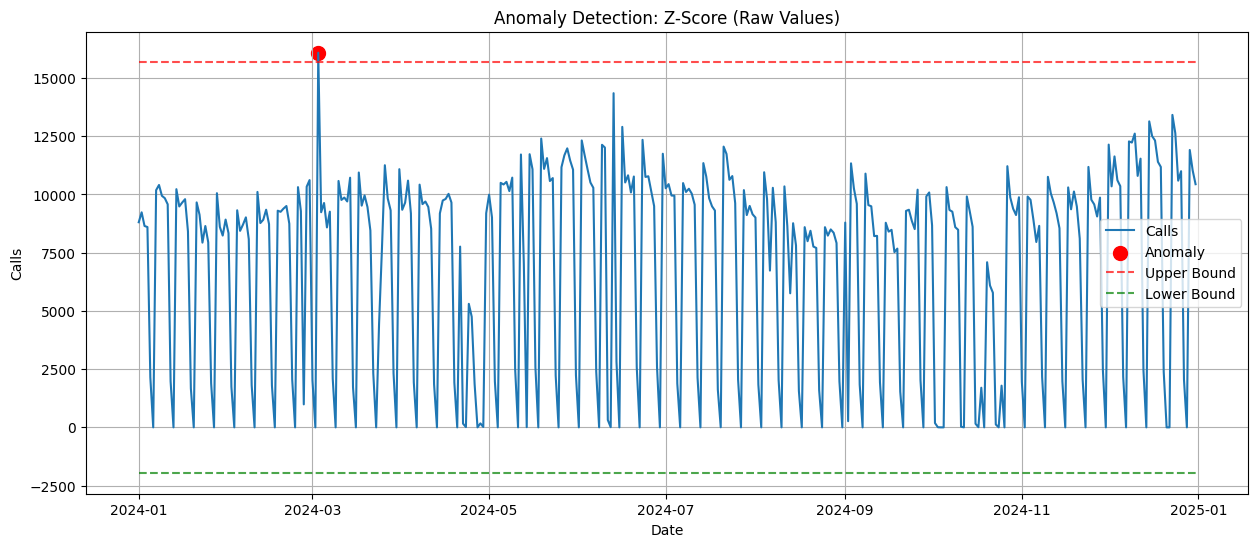


Anomalies detected by Z-Score (Raw Values):
            calls
date             
2024-03-03  16088


In [10]:
# --- 2. Z-Score Method on Raw Values ---
print("\n--- Z-Score on Raw Values ---")
ts_zscore = ts.copy()
mean_calls = ts_zscore['calls'].mean()
std_calls = ts_zscore['calls'].std()
# z_score_threshold = 3 # Common threshold
z_score_threshold = 2 # Common threshold

ts_zscore['z_score'] = (ts_zscore['calls'] - mean_calls) / std_calls
ts_zscore['anomaly_zscore_raw'] = abs(ts_zscore['z_score']) > z_score_threshold

# For plotting bounds (though Z-score is usually just about the points)
ts_zscore['upper_bound'] = mean_calls + z_score_threshold * std_calls
ts_zscore['lower_bound'] = mean_calls - z_score_threshold * std_calls

plot_anomalies(ts_zscore, 'anomaly_zscore_raw', 'Z-Score (Raw Values)')

In [14]:
ts_zscore['calls'].plot(kind='histogram')

## IQR Method on Raw Values


--- IQR on Raw Values ---


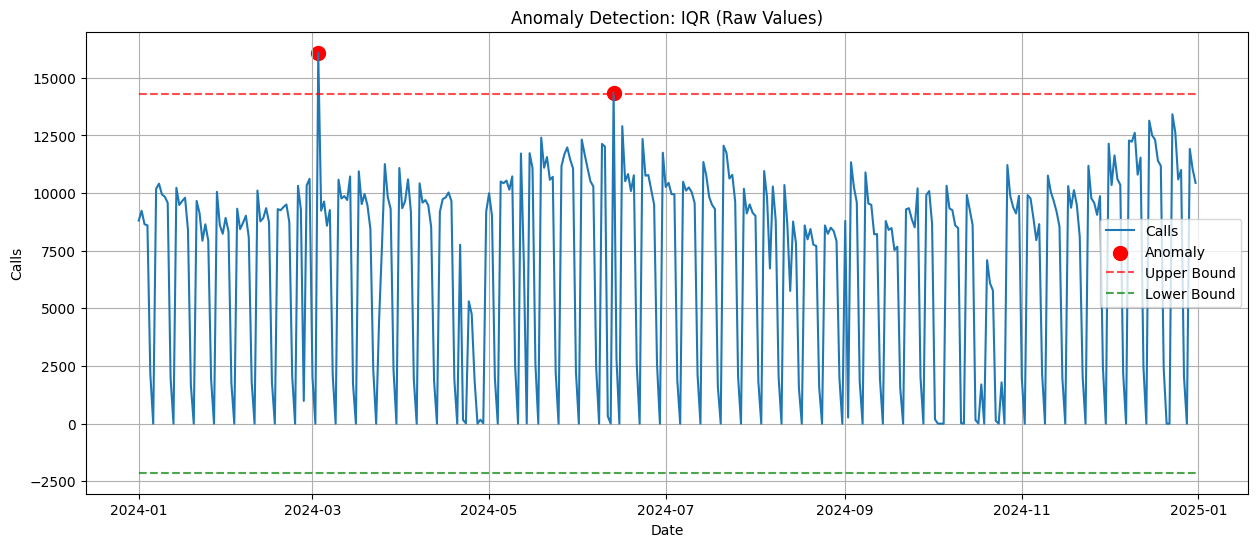


Anomalies detected by IQR (Raw Values):
            calls
date             
2024-03-03  16088
2024-06-13  14350


In [15]:
# --- 3. IQR Method on Raw Values ---
print("\n--- IQR on Raw Values ---")
ts_iqr = ts.copy()
Q1 = ts_iqr['calls'].quantile(0.25)
Q3 = ts_iqr['calls'].quantile(0.75)
IQR = Q3 - Q1
# iqr_multiplier = 1.5 # Common multiplier
iqr_multiplier = 0.5

lower_bound_iqr = Q1 - iqr_multiplier * IQR
upper_bound_iqr = Q3 + iqr_multiplier * IQR

ts_iqr['anomaly_iqr_raw'] = (ts_iqr['calls'] < lower_bound_iqr) | (ts_iqr['calls'] > upper_bound_iqr)
ts_iqr['lower_bound'] = lower_bound_iqr # For plotting
ts_iqr['upper_bound'] = upper_bound_iqr # For plotting

plot_anomalies(ts_iqr, 'anomaly_iqr_raw', 'IQR (Raw Values)')

## Moving Average (MA)


--- Moving Average (Bollinger Bands Style) ---


<ipython-input-15-3418409452>:15: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

<ipython-input-15-3418409452>:16: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



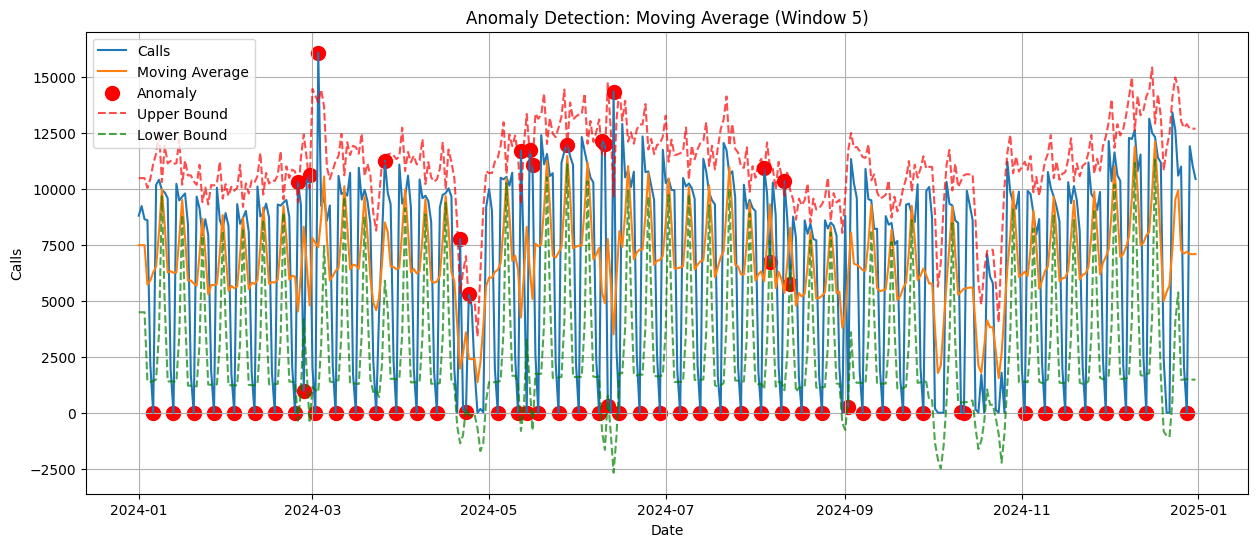


Anomalies detected by Moving Average (Window 5):
            calls
date             
2024-01-06      0
2024-01-13      0
2024-01-20      0
2024-01-27      0
2024-02-03      0
...           ...
2024-11-23      0
2024-11-30      0
2024-12-07      0
2024-12-14      0
2024-12-28      0

[68 rows x 1 columns]


In [ ]:
# --- Moving Average (MA) / Bollinger Bands Style ---
print("\n--- Moving Average (Bollinger Bands Style) ---")
ts_ma = ts.copy()
ma_window = 5 # Window size for moving average
# ma_std_multiplier = 2.5 # Number of std deviations for bounds
ma_std_multiplier = 1 # Number of std deviations for bounds

ts_ma['moving_avg'] = ts_ma['calls'].rolling(window=ma_window, center=True).mean()
ts_ma['moving_std'] = ts_ma['calls'].rolling(window=ma_window, center=True).std()

ts_ma['upper_bound'] = ts_ma['moving_avg'] + ma_std_multiplier * ts_ma['moving_std']
ts_ma['lower_bound'] = ts_ma['moving_avg'] - ma_std_multiplier * ts_ma['moving_std']

# Fill NaNs at the beginning/end due to rolling window with global bounds or drop them
ts_ma.fillna(method='bfill', inplace=True) # backfill for start
ts_ma.fillna(method='ffill', inplace=True) # frontfill for end

ts_ma['anomaly_ma'] = (ts_ma['calls'] < ts_ma['lower_bound']) | (ts_ma['calls'] > ts_ma['upper_bound'])
plot_anomalies(ts_ma, 'anomaly_ma', f'Moving Average (Window {ma_window})')

## Exponentially Weighted Moving Average (EWMA)


--- Exponentially Weighted Moving Average (EWMA) ---


<ipython-input-16-1116908535>:17: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

<ipython-input-16-1116908535>:18: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



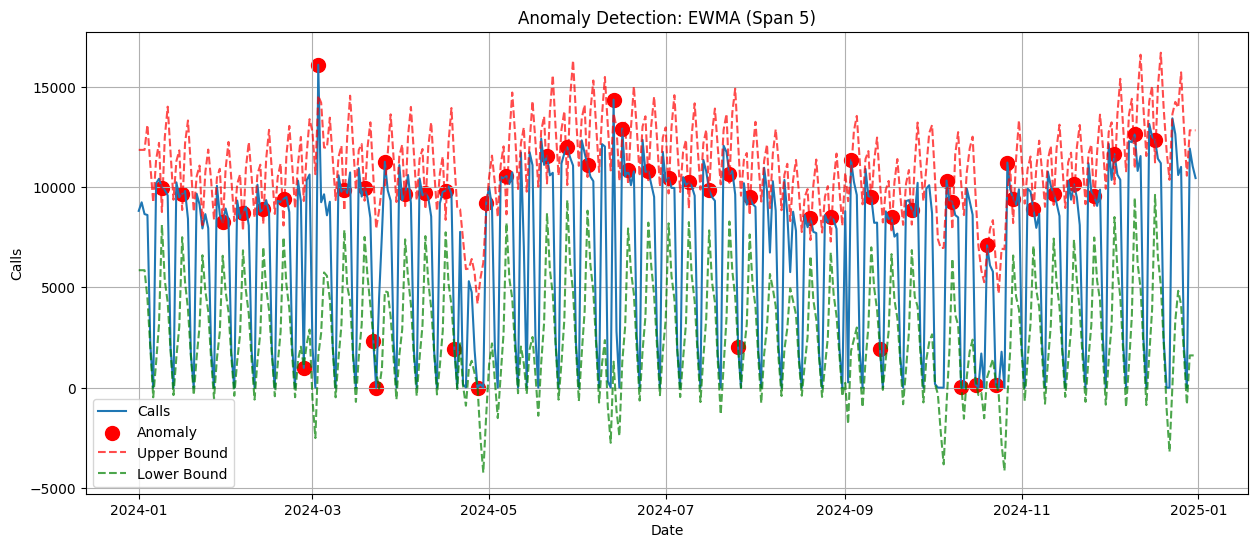


Anomalies detected by EWMA (Span 5):
            calls
date             
2024-01-09   9944
2024-01-16   9653
2024-01-30   8236
2024-02-06   8705
2024-02-13   8915
2024-02-20   9395
2024-02-27    987
2024-03-03  16088
2024-03-12   9868
2024-03-19   9960
2024-03-22   2321
2024-03-23      0
2024-03-26  11257
2024-04-02   9649
2024-04-09   9698
2024-04-16   9809
2024-04-19   1923
2024-04-27      0
2024-04-30   9196
2024-05-07  10542
2024-05-21  11563
2024-05-28  11981
2024-06-04  11088
2024-06-13  14350
2024-06-16  12904
2024-06-18  10824
2024-06-25  10782
2024-07-02  10445
2024-07-09  10246
2024-07-16   9838
2024-07-23  10631
2024-07-26   2046
2024-07-30   9509
2024-08-20   8442
2024-08-27   8500
2024-09-03  11338
2024-09-10   9493
2024-09-13   1935
2024-09-17   8482
2024-09-24   8868
2024-10-06  10317
2024-10-08   9261
2024-10-11     28
2024-10-16    155
2024-10-20   7091
2024-10-23    125
2024-10-27  11215
2024-10-29   9389
2024-11-05   8914
2024-11-12   9663
2024-11-19  10129
2024-11-

In [16]:
# --- 6. Exponentially Weighted Moving Average (EWMA) ---
print("\n--- Exponentially Weighted Moving Average (EWMA) ---")
ts_ewma = ts.copy()
ewma_span = 5 # Span for EWMA, similar to window but gives more weight to recent points
ewma_std_multiplier = 1

ts_ewma['ewma'] = ts_ewma['calls'].ewm(span=ewma_span, adjust=False).mean()
# For EWMA, std deviation calculation can vary.
# One common way is to use a rolling std deviation of the original series or residuals.
# Let's use rolling std of original series for simplicity here.
ts_ewma['rolling_std_for_ewma'] = ts_ewma['calls'].rolling(window=ewma_span, center=True).std()

ts_ewma['upper_bound'] = ts_ewma['ewma'] + ewma_std_multiplier * ts_ewma['rolling_std_for_ewma']
ts_ewma['lower_bound'] = ts_ewma['ewma'] - ewma_std_multiplier * ts_ewma['rolling_std_for_ewma']

# Fill NaNs at the beginning/end due to rolling window for std
ts_ewma.fillna(method='bfill', inplace=True) # backfill
ts_ewma.fillna(method='ffill', inplace=True) # frontfill

ts_ewma['anomaly_ewma'] = (ts_ewma['calls'] < ts_ewma['lower_bound']) | (ts_ewma['calls'] > ts_ewma['upper_bound'])
plot_anomalies(ts_ewma, 'anomaly_ewma', f'EWMA (Span {ewma_span})')

## Isolation Forest


--- Isolation Forest ---


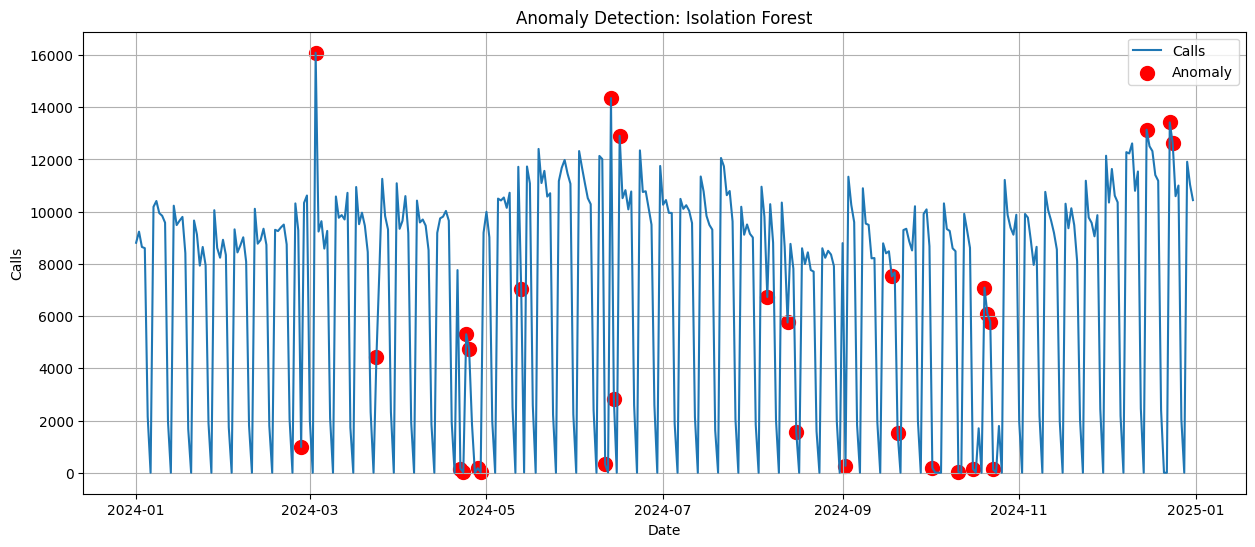


Anomalies detected by Isolation Forest:
            calls
date             
2024-02-27    987
2024-03-03  16088
2024-03-24   4442
2024-04-22    160
2024-04-23     12
2024-04-24   5304
2024-04-25   4751
2024-04-28    171
2024-04-29     17
2024-05-13   7022
2024-06-11    318
2024-06-13  14350
2024-06-14   2821
2024-06-16  12904
2024-08-06   6732
2024-08-13   5757
2024-08-16   1560
2024-09-02    265
2024-09-18   7524
2024-09-20   1536
2024-10-02    185
2024-10-11     28
2024-10-16    155
2024-10-20   7091
2024-10-21   6092
2024-10-22   5782
2024-10-23    125
2024-12-15  13140
2024-12-23  13418
2024-12-24  12634


In [ ]:
# --- 7. Isolation Forest ---
print("\n--- Isolation Forest ---")
ts_iforest = ts.copy()
# Reshape data for Isolation Forest (expects 2D array)
data_for_iforest = ts_iforest[['calls']].values

# Contamination: expected proportion of outliers. 'auto' or a float.
# If you have an idea of how many anomalies to expect (e.g., 1-5%), set it.
# Let's say we expect around 8% anomalies from our injected ones.
# Adjust this based on your data.
iso_forest = IsolationForest(n_estimators=100, contamination=0.08, random_state=42)
ts_iforest['anomaly_iforest_pred'] = iso_forest.fit_predict(data_for_iforest)

# Predictions are -1 for anomalies, 1 for inliers. Convert to boolean.
ts_iforest['anomaly_iforest'] = ts_iforest['anomaly_iforest_pred'] == -1

plot_anomalies(ts_iforest, 'anomaly_iforest', 'Isolation Forest')

# Contextual Anomalies Detection

Contextual anomalies are those that are unusual given their specific time context (e.g., day of the week, season of the year)

In [17]:
# --- Helper function for plotting ---
def plot_contextual_anomalies(df, anomaly_column_name, title_suffix, y_col='calls',
                              yhat_lower_col=None, yhat_upper_col=None, forecast_col=None):
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df[y_col], label=y_col.capitalize(), zorder=1)

    if forecast_col and forecast_col in df.columns:
        plt.plot(df.index, df[forecast_col], label='Forecast/Model', linestyle='--', color='orange', zorder=2)

    if yhat_lower_col and yhat_upper_col and yhat_lower_col in df.columns and yhat_upper_col in df.columns:
        plt.fill_between(df.index, df[yhat_lower_col], df[yhat_upper_col],
                         color='gray', alpha=0.3, label='Confidence Interval')

    anomalies = df[df[anomaly_column_name]]
    plt.scatter(anomalies.index, anomalies[y_col], color='red', label='Anomaly', s=100, marker='o', zorder=3)

    plt.title(f'Contextual Anomaly Detection: {title_suffix}')
    plt.xlabel('Date')
    plt.ylabel('Calls')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"\nAnomalies detected by {title_suffix}:")
    if not anomalies.empty:
        print(anomalies[[y_col]])
    else:
        print("No anomalies detected.")

## STL Decomposition for Anomaly Detection


--- STL Decomposition ---


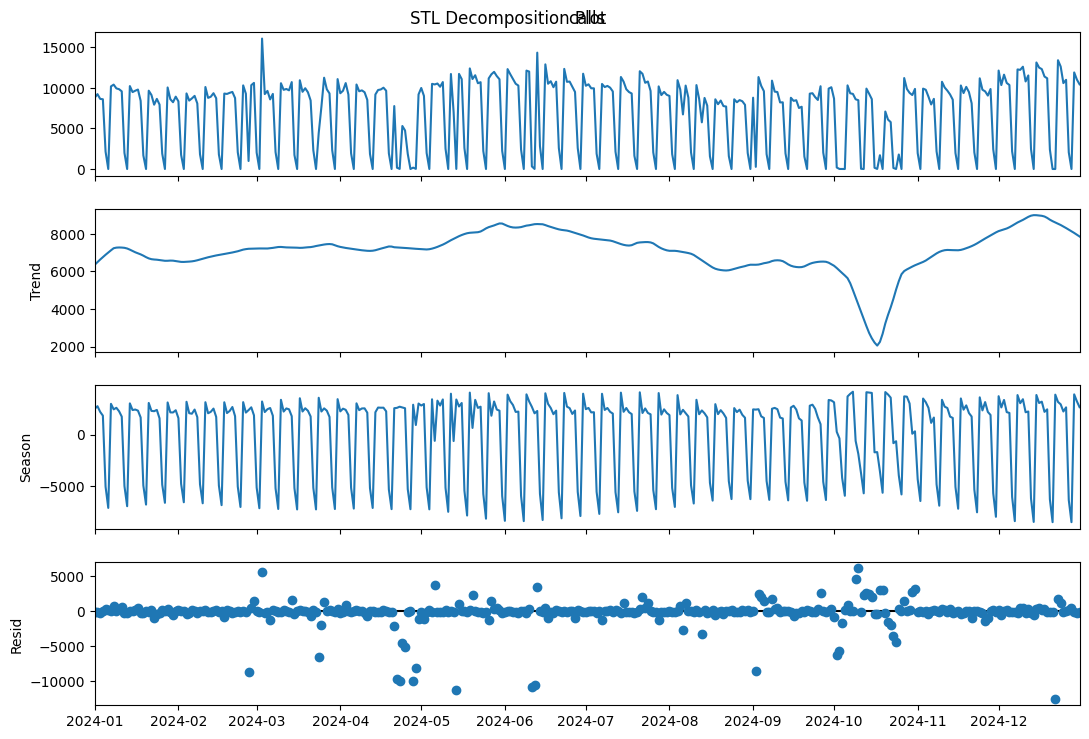

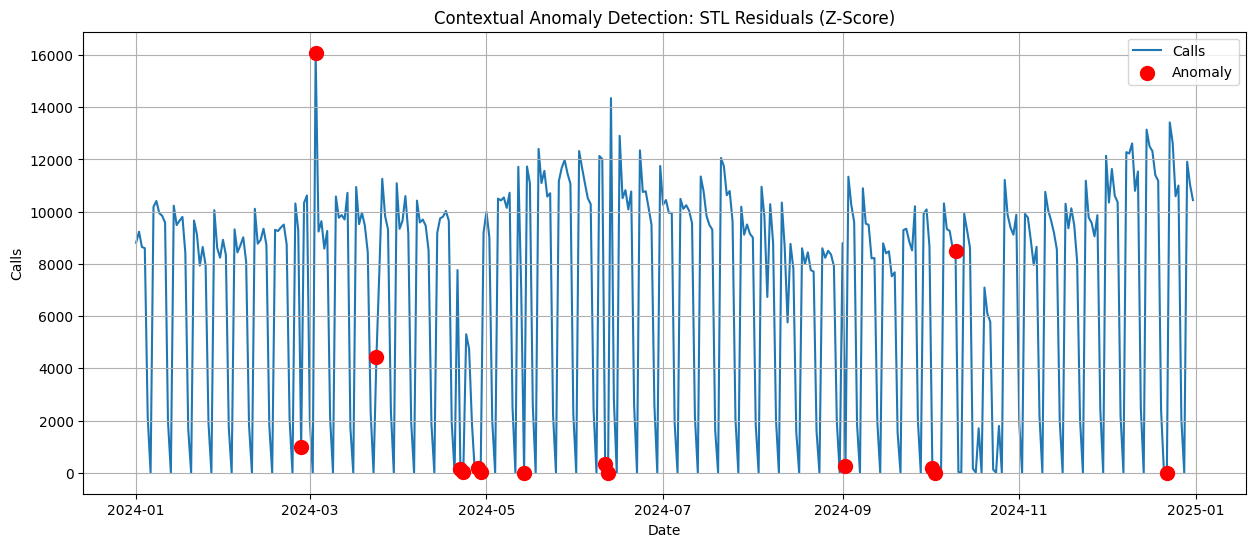


Anomalies detected by STL Residuals (Z-Score):
            calls
date             
2024-02-27    987
2024-03-03  16088
2024-03-24   4442
2024-04-22    160
2024-04-23     12
2024-04-28    171
2024-04-29     17
2024-05-14      8
2024-06-11    318
2024-06-12      7
2024-09-02    265
2024-10-02    185
2024-10-03      5
2024-10-10   8484
2024-12-22      0


In [ ]:
# --- 2. STL Decomposition for Anomaly Detection ---
print("\n--- STL Decomposition ---")
ts_stl = ts.copy()

# STL Decomposition: period=7 for weekly seasonality with daily data
stl_period = 7
if len(ts_stl) >= 2 * stl_period:
    stl = STL(ts_stl['calls'], period=stl_period, robust=True) # robust=True helps with existing outliers
    res_stl = stl.fit()

    # Plot decomposition components
    fig = res_stl.plot()
    fig.set_size_inches(12, 8)
    plt.suptitle("STL Decomposition Plot", y=0.95)
    plt.show()

    ts_stl['residuals_stl'] = res_stl.resid
    ts_stl['trend_stl'] = res_stl.trend
    ts_stl['seasonal_stl'] = res_stl.seasonal

    # Identify anomalies in residuals using Z-score
    residuals_mean = ts_stl['residuals_stl'].mean()
    residuals_std = ts_stl['residuals_stl'].std()
    stl_z_threshold = 2.5 # Can be more sensitive for residuals

    ts_stl['anomaly_stl'] = abs((ts_stl['residuals_stl'] - residuals_mean) / residuals_std) > stl_z_threshold
    plot_contextual_anomalies(ts_stl, 'anomaly_stl', 'STL Residuals (Z-Score)')
else:
    print(f"Time series too short for STL decomposition with period {stl_period}. Skipping STL.")

## Prophet for Anomaly Detection

In [18]:
from datetime import datetime

isr_holidays = [
    {'holiday': 'Municipal Election Day', 'ds': datetime(2024, 2, 27), 'lower_window': 0, 'upper_window': 1},

    {'holiday': 'Purim', 'ds': datetime(2024, 3, 24), 'lower_window': -1, 'upper_window': 1},
    {'holiday': 'Purim', 'ds': datetime(2025, 3, 13), 'lower_window': -1, 'upper_window': 1},

    {'holiday': 'Passover_1', 'ds': datetime(2024, 4, 22), 'lower_window': -1, 'upper_window': 1},
    {'holiday': 'Passover_1', 'ds': datetime(2025, 4, 13), 'lower_window': -1, 'upper_window': 1},

    {'holiday': 'Passover_7', 'ds': datetime(2024, 4, 28), 'lower_window': -1, 'upper_window': 1},
    {'holiday': 'Passover_7', 'ds': datetime(2025, 4, 19), 'lower_window': -1, 'upper_window': 1},

    # {'holiday': 'Yom_HaShoah', 'ds': datetime(2024, 5, 6)},
    # {'holiday': 'Yom_HaZikaron', 'ds': datetime(2024, 5, 13)},
    {'holiday': 'Yom_HaAtzmaut', 'ds': datetime(2024, 5, 14), 'lower_window': -1, 'upper_window': 1},
    {'holiday': 'Yom_HaAtzmaut', 'ds': datetime(2025, 5, 1), 'lower_window': -1, 'upper_window': 1},

    # {'holiday': 'Lag_BaOmer', 'ds': datetime(2024, 5, 26)},
    {'holiday': 'Shavuot', 'ds': datetime(2024, 6, 12), 'lower_window': -1, 'upper_window': 1},
    {'holiday': 'Rosh_Hashanah_1', 'ds': datetime(2024, 10, 3), 'lower_window': -1, 'upper_window': 2},
    {'holiday': 'Yom_Kippur', 'ds': datetime(2024, 10, 12), 'lower_window': -1, 'upper_window': 1},
    {'holiday': 'Sukkot_1', 'ds': datetime(2024, 10, 17), 'lower_window': -1, 'upper_window': 1},
    # {'holiday': 'Sukkot_Hoshana_Rabbah', 'ds': datetime(2024, 10, 23), 'lower_window': -1, 'upper_window': 1},
    {'holiday': 'Simchat_Torah', 'ds': datetime(2024, 10, 24), 'lower_window': -1, 'upper_window': 1},
]
holidays_df = pd.DataFrame(isr_holidays)


--- Prophet ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmpld36meat/6ju8bi43.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpld36meat/8uca2pp6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35074', 'data', 'file=/tmp/tmpld36meat/6ju8bi43.json', 'init=/tmp/tmpld36meat/8uca2pp6.json', 'output', 'file=/tmp/tmpld36meat/prophet_modelz1fodf7l/prophet_model-20250612163528.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:35:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:35:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


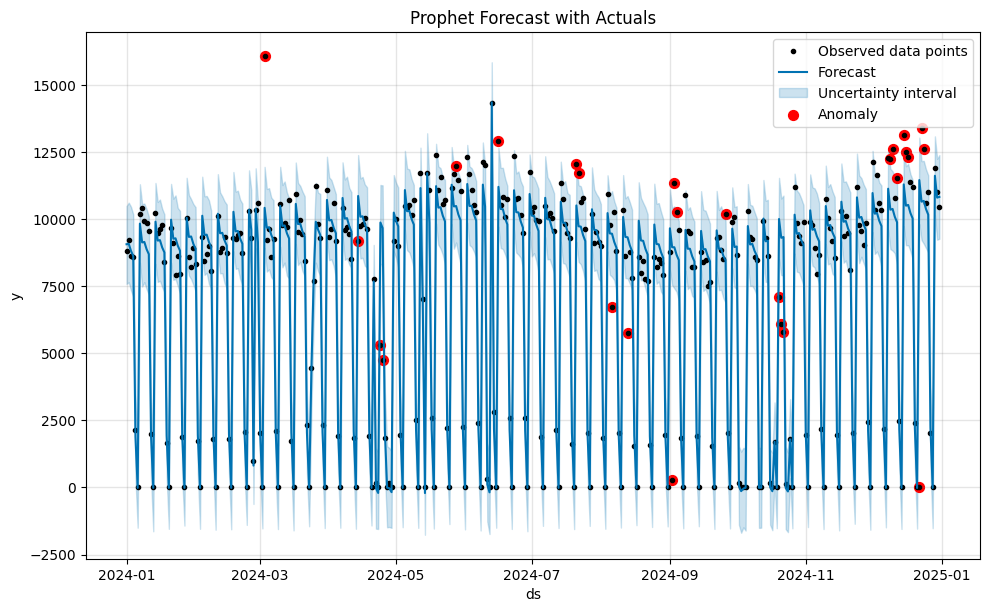

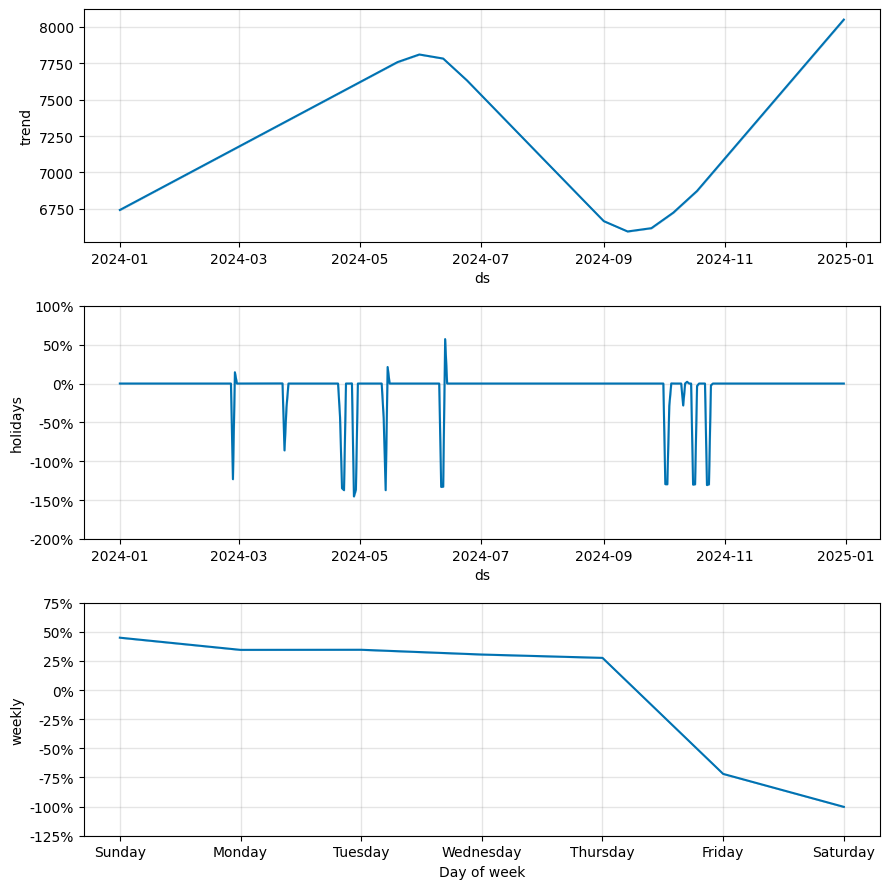

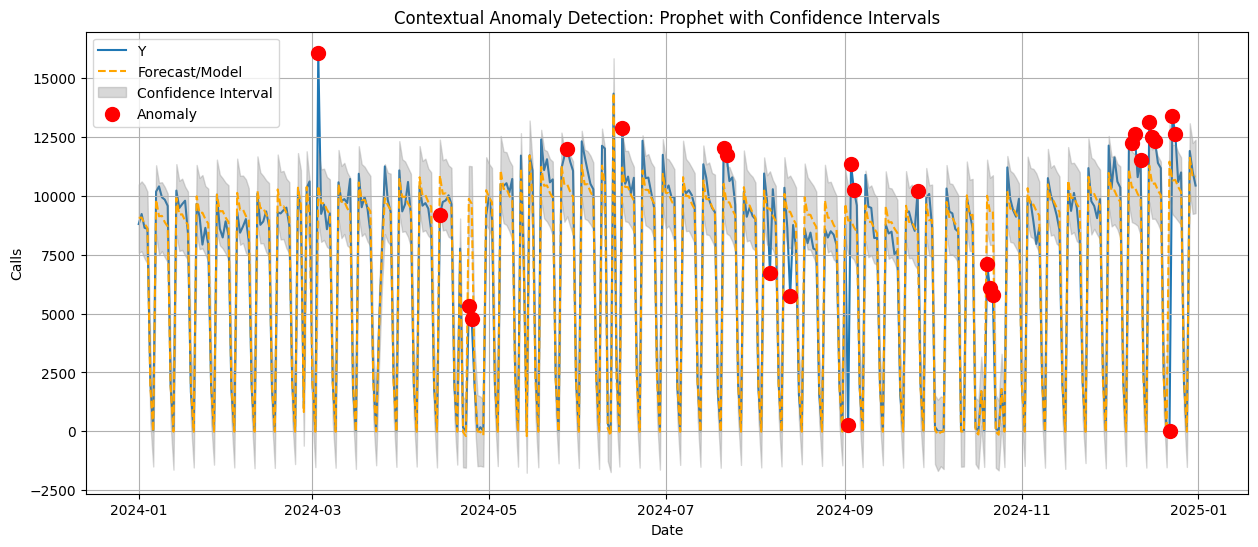


Anomalies detected by Prophet with Confidence Intervals:
                y
ds               
2024-03-03  16088
2024-04-14   9187
2024-04-24   5304
2024-04-25   4751
2024-05-28  11981
2024-06-16  12904
2024-07-21  12057
2024-07-22  11740
2024-08-06   6732
2024-08-13   5757
2024-09-02    265
2024-09-03  11338
2024-09-04  10259
2024-09-26  10207
2024-10-20   7091
2024-10-21   6092
2024-10-22   5782
2024-12-09  12230
2024-12-10  12615
2024-12-12  11539
2024-12-15  13140
2024-12-16  12506
2024-12-17  12319
2024-12-22      0
2024-12-23  13418
2024-12-24  12634


In [19]:
# --- 3. Prophet for Anomaly Detection ---
print("\n--- Prophet ---")
ts_prophet = ts.reset_index().rename(columns={'date': 'ds', 'calls': 'y'})

# Prophet model
# Prophet automatically detects weekly seasonality if data > 2 cycles.
# Yearly seasonality is on by default but won't be very effective with <1 year of data.
# Daily seasonality can be added if sub-daily data, or if specific daily patterns exist beyond weekly.
model_prophet = Prophet(
    holidays = holidays_df,
    seasonality_mode="multiplicative",
    yearly_seasonality=False, # Not enough data for yearly
    weekly_seasonality=True,
    daily_seasonality=False, # Assuming no strong intra-day pattern beyond weekly
    # interval_width=0.95 # How wide the uncertainty interval is. Higher makes it harder to flag anomalies.
)
# Suppress Prophet's informational messages during fitting for cleaner output
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)


model_prophet.fit(ts_prophet)

# Make predictions for the historical period
forecast_prophet = model_prophet.predict(ts_prophet[['ds']])

# Merge forecast back to original ts structure
ts_prophet_results = pd.merge(ts_prophet, forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
ts_prophet_results = ts_prophet_results.set_index('ds')

# Identify anomalies
ts_prophet_results['anomaly_prophet'] = (ts_prophet_results['y'] < ts_prophet_results['yhat_lower']) | \
                                        (ts_prophet_results['y'] > ts_prophet_results['yhat_upper'])

# Plot Prophet forecast and anomalies
fig1 = model_prophet.plot(forecast_prophet)
plt.title("Prophet Forecast with Actuals")
ax = fig1.gca()
anomalies_prophet_df = ts_prophet_results[ts_prophet_results['anomaly_prophet']]
ax.scatter(anomalies_prophet_df.index, anomalies_prophet_df['y'], color='red', s=50, label='Anomaly')
plt.legend()
plt.show()

# Plot components
fig2 = model_prophet.plot_components(forecast_prophet)
plt.show()

# Use our custom plotting function
plot_contextual_anomalies(ts_prophet_results, 'anomaly_prophet', 'Prophet with Confidence Intervals',
                          y_col='y', yhat_lower_col='yhat_lower', yhat_upper_col='yhat_upper',
                          forecast_col='yhat')

## Seasonal Z-Score


--- Seasonal Z-Score (Day of Week) ---


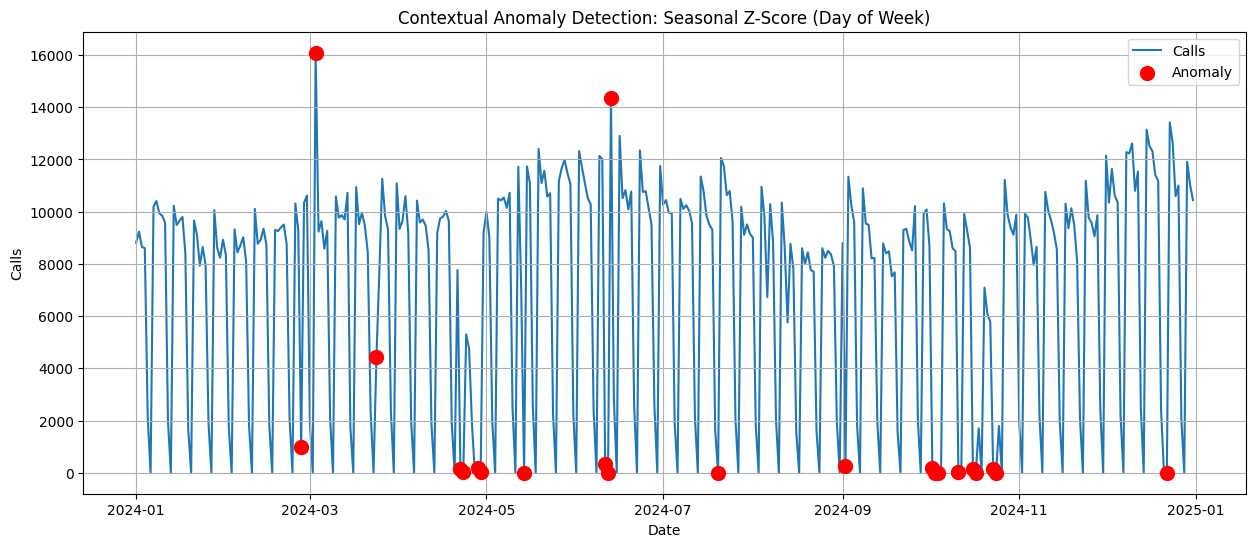


Anomalies detected by Seasonal Z-Score (Day of Week):
            calls
date             
2024-02-27    987
2024-03-03  16088
2024-03-24   4442
2024-04-22    160
2024-04-23     12
2024-04-28    171
2024-04-29     17
2024-05-14      8
2024-06-11    318
2024-06-12      7
2024-06-13  14350
2024-07-20      4
2024-09-02    265
2024-10-02    185
2024-10-03      5
2024-10-04      0
2024-10-11     28
2024-10-16    155
2024-10-17      7
2024-10-23    125
2024-10-24      1
2024-12-22      0


In [ ]:
# --- 4. Seasonal Z-Score ---
# (e.g., Z-score based on day of the week)
print("\n--- Seasonal Z-Score (Day of Week) ---")
ts_seasonal_z = ts.copy()

# Add day of week as a feature (0=Monday, 6=Sunday)
ts_seasonal_z['day_of_week'] = ts_seasonal_z.index.dayofweek

# Calculate mean and std for each day of the week
seasonal_stats = ts_seasonal_z.groupby('day_of_week')['calls'].agg(['mean', 'std']).reset_index()
seasonal_stats = seasonal_stats.rename(columns={'mean': 'seasonal_mean', 'std': 'seasonal_std'})

# Merge seasonal stats back
ts_seasonal_z = pd.merge(ts_seasonal_z.reset_index(), seasonal_stats, on='day_of_week', how='left').set_index('date')

# Handle cases where std might be 0 or NaN (e.g., if only one data point for a day of week)
# For such cases, anomaly detection isn't reliable for that specific point using this method
# We can fill NaNs in seasonal_std with a very small number or a global std if preferred.
# Here, if std is 0 or NaN, z_score will be NaN or inf, we can treat those as non-anomalies or handle differently.
ts_seasonal_z['seasonal_std'] = ts_seasonal_z['seasonal_std'].fillna(ts_seasonal_z['calls'].std()) # Fallback
ts_seasonal_z['seasonal_std'] = ts_seasonal_z['seasonal_std'].replace(0, ts_seasonal_z['calls'].std())   # Fallback for 0 std

# Calculate seasonal Z-score
ts_seasonal_z['seasonal_z_score'] = (ts_seasonal_z['calls'] - ts_seasonal_z['seasonal_mean']) / ts_seasonal_z['seasonal_std']

# Identify anomalies
seasonal_z_threshold = 2.0 # Threshold can be adjusted
ts_seasonal_z['anomaly_seasonal_z'] = abs(ts_seasonal_z['seasonal_z_score']) > seasonal_z_threshold

plot_contextual_anomalies(ts_seasonal_z, 'anomaly_seasonal_z', 'Seasonal Z-Score (Day of Week)')